## Neo Bank Churn Prediction | Machine learning 

### Description
Your stakeholders set a very high priority to explainability and do not trust black box modelling, thus it has been decided that you can only deploy a single supervised model architecture: No blending, no stacking. At least the data scientist, whose role you are replacing, has been able to convince the stakeholders that model orchestration is not a black box before he left.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/neo-bank-non-sub-churn-prediction/neo_bank_2008.png
/kaggle/input/neo-bank-non-sub-churn-prediction/train_2008.parquet
/kaggle/input/neo-bank-non-sub-churn-prediction/train_2020.parquet
/kaggle/input/neo-bank-non-sub-churn-prediction/sample_submission.csv
/kaggle/input/neo-bank-non-sub-churn-prediction/train_2019.parquet
/kaggle/input/neo-bank-non-sub-churn-prediction/handover_for_next_data_scientist.odt
/kaggle/input/neo-bank-non-sub-churn-prediction/train_2010.parquet
/kaggle/input/neo-bank-non-sub-churn-prediction/train_2011.parquet
/kaggle/input/neo-bank-non-sub-churn-prediction/fetch_bank_2007.png
/kaggle/input/neo-bank-non-sub-churn-prediction/train_2016.parquet
/kaggle/input/neo-bank-non-sub-churn-prediction/train_2017.parquet
/kaggle/input/neo-bank-non-sub-churn-prediction/train_2015.parquet
/kaggle/input/neo-bank-non-sub-churn-prediction/train_2009.parquet
/kaggle/input/neo-bank-non-sub-churn-prediction/train_2021.parquet
/kaggle/input/neo-bank-non-sub-churn-pred

Load python libraries

In [2]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
#%pip install pyarrow

In [5]:
file_path = '/kaggle/input/neo-bank-non-sub-churn-prediction/train_*.parquet'  
all_files = glob.glob(file_path)
data = pd.concat([pd.read_parquet(file) for file in all_files], ignore_index=True)

df = data.copy()

In [6]:
df.head(5)

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-17,0,0,...,393.145010,220.900654,0,[],"{'appointment': None, 'email': None, 'phone': ...",0,False,Amenity horticulturist,False,False
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-18,0,0,...,390.005729,221.147296,0,[],"{'appointment': None, 'email': None, 'phone': ...",1,False,Amenity horticulturist,False,False
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-19,0,0,...,393.209108,260.510535,0,[],"{'appointment': None, 'email': None, 'phone': ...",2,False,Amenity horticulturist,False,False
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-20,0,0,...,394.078294,203.214128,0,[],"{'appointment': None, 'email': None, 'phone': ...",3,False,Amenity horticulturist,False,False
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-21,0,0,...,395.174604,207.894467,0,"[whatsapp, email, email]","{'appointment': None, 'email': None, 'phone': ...",4,False,Amenity horticulturist,False,False


#### What is the name of custmers who churned so far and the total tenure

In [7]:
df[df['churn_due_to_fraud'] == 'True'].groupby(['name', 'country']).agg('count')


,,Id,customer_id,interest_rate,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,...,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud
name,country,,,,,,,,,,,,,,,,,,,,,


### What the total number distribution of churn due to fraud

In [8]:
df['model_predicted_fraud'].value_counts()

model_predicted_fraud
False    3924306
True        1752
Name: count, dtype: int64

The dataset is umbelance the almost 99.9% of the curtomer who didn't churned and 0.1% of custmer who churned with the tenure distribution

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3926058 entries, 0 to 3926057
Data columns (total 26 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   Id                        int64         
 1   customer_id               int64         
 2   interest_rate             float64       
 3   name                      object        
 4   country                   object        
 5   date_of_birth             object        
 6   address                   object        
 7   date                      datetime64[ns]
 8   atm_transfer_in           int64         
 9   atm_transfer_out          int64         
 10  bank_transfer_in          int64         
 11  bank_transfer_out         int64         
 12  crypto_in                 int64         
 13  crypto_out                int64         
 14  bank_transfer_in_volume   float64       
 15  bank_transfer_out_volume  float64       
 16  crypto_in_volume          float64       
 17  crypto_o

In [10]:
df["churn_due_to_fraud"].value_counts()

churn_due_to_fraud
False    3926031
True          27
Name: count, dtype: int64

In [11]:
df.isna().sum()

Id                          0
customer_id                 0
interest_rate               0
name                        0
country                     0
date_of_birth               0
address                     0
date                        0
atm_transfer_in             0
atm_transfer_out            0
bank_transfer_in            0
bank_transfer_out           0
crypto_in                   0
crypto_out                  0
bank_transfer_in_volume     0
bank_transfer_out_volume    0
crypto_in_volume            0
crypto_out_volume           0
complaints                  0
touchpoints                 0
csat_scores                 0
tenure                      0
from_competitor             0
job                         0
churn_due_to_fraud          0
model_predicted_fraud       0
dtype: int64

In [12]:
# the code below is use to check for duplicate value in the dataset
# Exclude columns with unhashable types (like lists or dicts)
unhashable_cols = ['touchpoints', 'csat_scores']
df.drop(columns=unhashable_cols, errors='ignore').duplicated().sum()

0

In [13]:
df.drop(["Id","customer_id","name", "address", "complaints","csat_scores"],axis=1, inplace=True)

In [14]:
from datetime import datetime

# Ensure dates are in datetime format
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extracting age
df['age'] = ((df['date'] - df['date_of_birth']).dt.days / 365).fillna(0).astype(int)

# Extracting year, month, and weekday name
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day_name()

# Convert the target column to numerical (example columns used here)
df['model_predicted_fraud'] = df['model_predicted_fraud'].astype("int64")
df['churn_due_to_fraud'] = df['churn_due_to_fraud'].astype("int64")

# Saving DataFrame to CSV 
df.to_csv('churn_data.csv', index=False)

# Confirming the save
print(f"DataFrame saved to churn_data size has {df.shape[0]} rows and {df.shape[1]} columns.")


DataFrame saved to churn_data size has 3926058 rows and 24 columns.


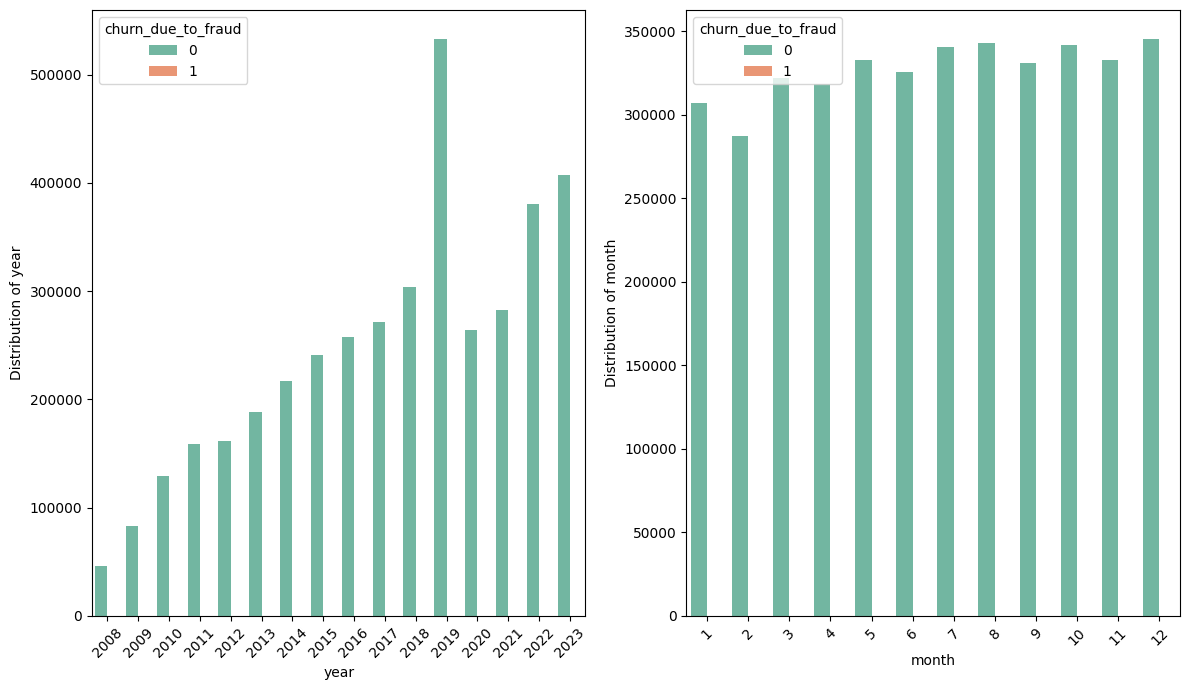

In [15]:
date_trending = ['year', 'month']

plt.figure(figsize=(12, 7))

# Loop through numerical features
for i, column in enumerate(date_trending, start=1):  # Use enumerate to get the index
    plt.subplot(1, 2, i)  # Adjust the number of rows and columns as needed
    sns.countplot( x = df[column], hue=df['churn_due_to_fraud'], palette='Set2')
    plt.xlabel(column)
    plt.xticks(rotation=45)

    plt.ylabel(f'Distribution of {column}')

plt.tight_layout()
plt.show()

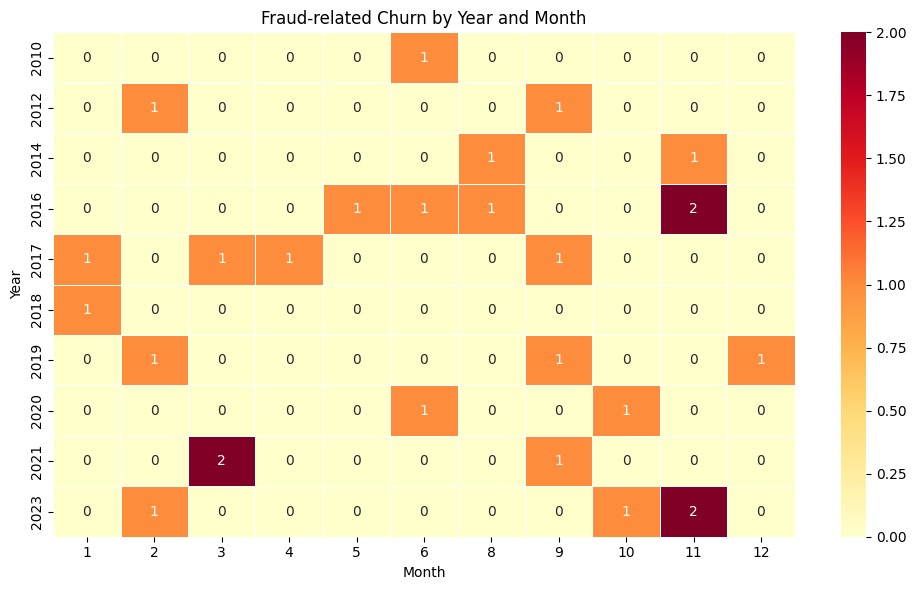

In [16]:
# Create a pivot table
heatmap_data = df[df['churn_due_to_fraud'] == 1].groupby(['year', 'month']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5)
plt.title('Fraud-related Churn by Year and Month')
plt.ylabel('Year')
plt.xlabel('Month')
plt.tight_layout()
plt.show()


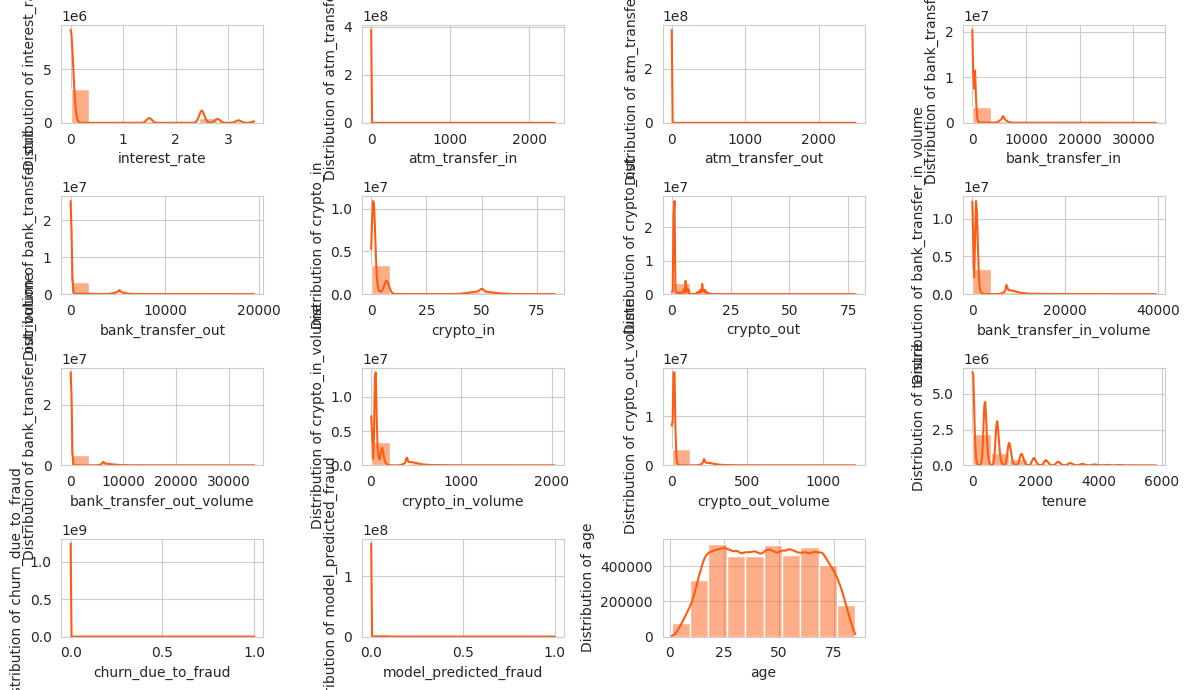

In [17]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Example to get numberic features

sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))

# Loop through numerical features
for i, column in enumerate(numerical_features, start=1):  # Use enumerate to get the index
    plt.subplot(4, 4, i)  # Adjust the number of rows and columns as needed
    sns.histplot(df[column], bins=10, kde=True, color="#FC5D13")
    plt.xlabel(column)
    plt.ylabel(f'Distribution of {column}')

plt.tight_layout()
plt.show()


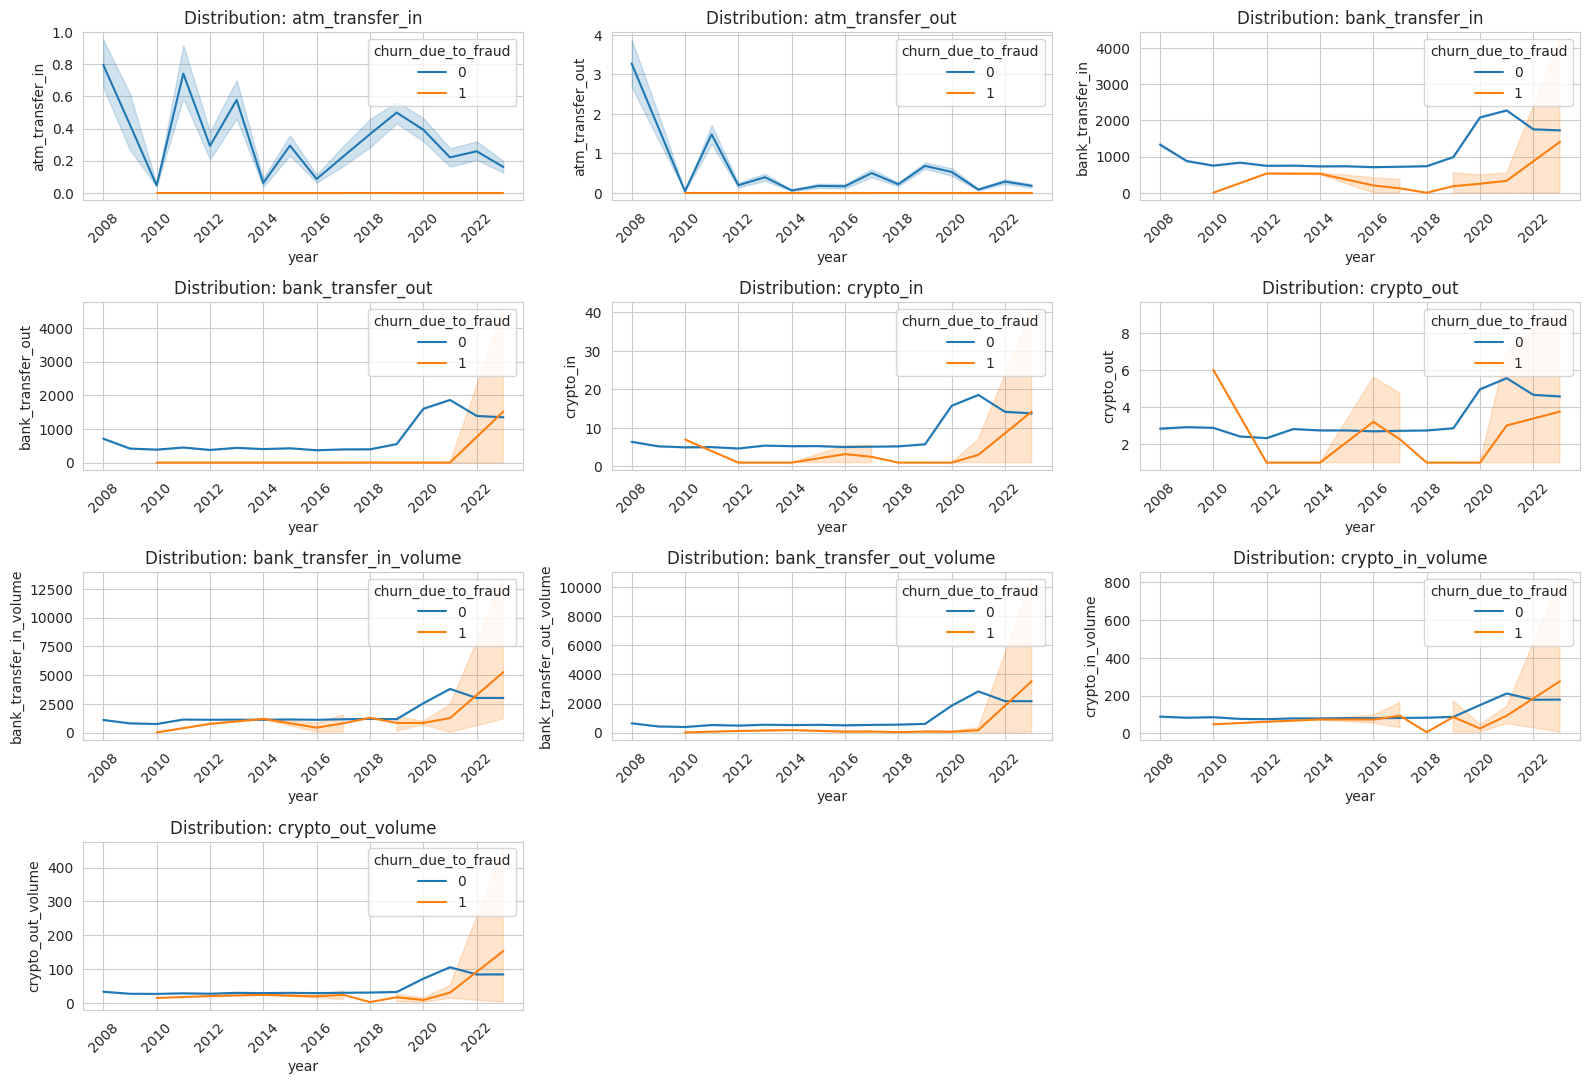

In [18]:
# Corrected version
feauture_tranding = [
    'atm_transfer_in', 'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
    'crypto_in', 'crypto_out', 'bank_transfer_in_volume', 'bank_transfer_out_volume',
    'crypto_in_volume', 'crypto_out_volume']

plt.figure(figsize=(16,13))  # Adjusting figure size
#sns.set_palette("rocket_r")  # Setting the color palette

for i, c in enumerate(feauture_tranding):
    plt.subplot(5, 3, i + 1)  # Fix subplot indexing
    sns.lineplot(data=df, x=df["year"], y=df[c], hue=df["churn_due_to_fraud"])
    plt.xticks(rotation=45)
    plt.title(f"Distribution: {c}")
    plt.tight_layout()

plt.show()


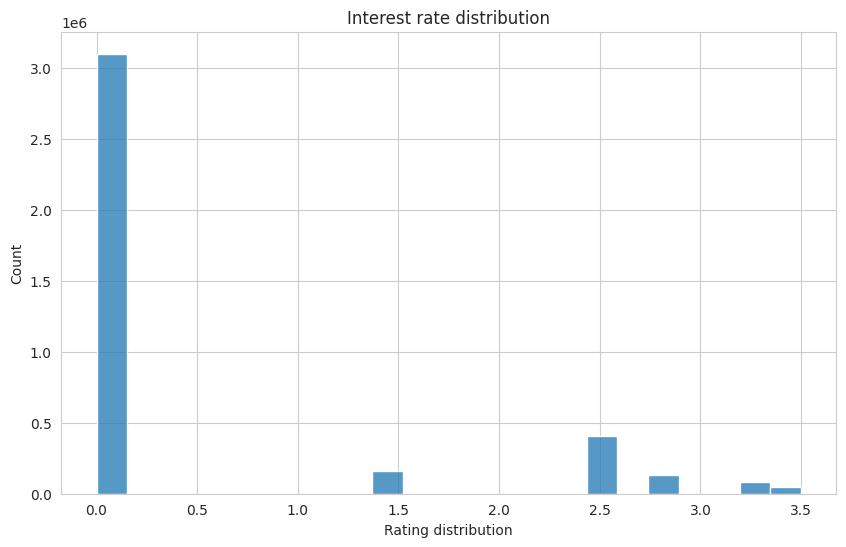

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(x='interest_rate', data=df, palette='rocket')
plt.title("Interest rate distribution")
plt.xlabel("Rating distribution")
plt.ylabel("Count")
plt.show()

### Check the correlation

In [20]:
# Select numerical features
df_num = df.select_dtypes(include=['float64', 'int64'])

# Calculate the Pearson correlation matrix
corr_matrix = df_num.corr()

# Select the target variable (assuming 'model_predicted_fraud' is the target)
target_corr = corr_matrix['model_predicted_fraud'].drop(labels=['model_predicted_fraud'])

# Filter features with a correlation greater than 0.1
top_features = target_corr[target_corr > 0.1].sort_values(ascending=False)

# Print the results
print("There are {} strongly correlated values with model_predicted_fraud:\n{}".format(len(top_features), top_features))


There are 1 strongly correlated values with model_predicted_fraud:
churn_due_to_fraud    0.124114
Name: model_predicted_fraud, dtype: float64


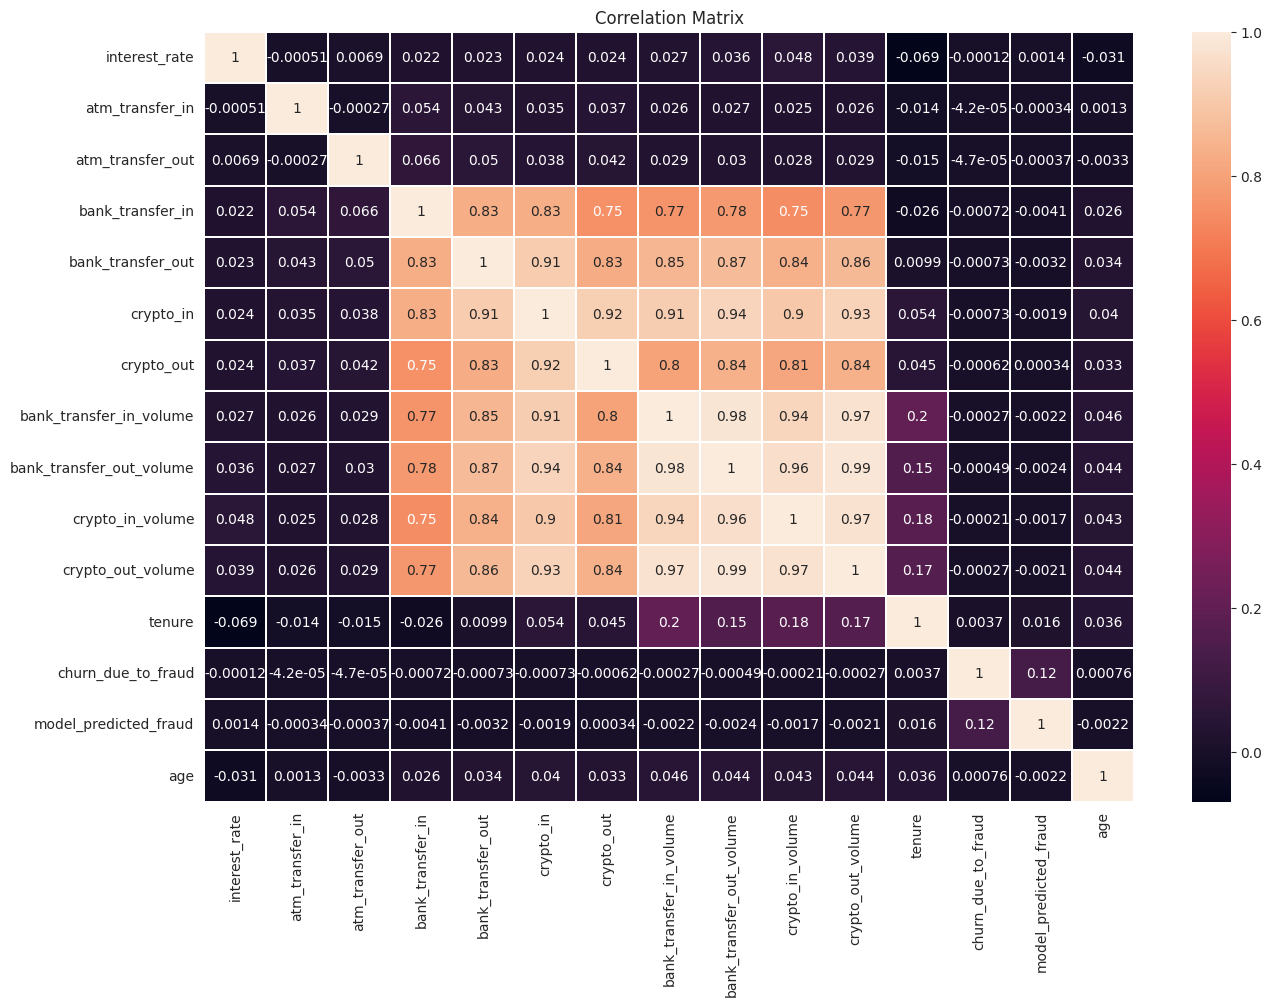

In [21]:
#Plot correlation matrix
plt.figure(figsize=(15,10))
df= df_num.corr()
sns.heatmap(df, annot=True, linewidth=0.02)
plt.title("Correlation Matrix")
plt.show()

## Machine Learning model train and test splite

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assume X and y are your feature matrix and target variable respectively
X = df_num.drop(['model_predicted_fraud'], axis=1).fillna(0)
y = df_num['model_predicted_fraud'].astype(int)

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#Check the train and test splite data shape
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")


Training dataset shape, X_train: (3140846, 14), y_train: (3140846,)
Testing dataset shape, X_test: (785212, 14), y_test: (785212,)


## 1. Traing Models

## 1.1 XGboost 

In [23]:
from xgboost import XGBClassifier

XGB = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27, 
 #objective='logloss'
)
#Fit the model
XGB.fit(X_train, y_train)
pred_xgb = XGB.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, pred_xgb)
F1_score = f1_score(y_test, pred_xgb)
print(f'Accuracy: {accuracy}')
print(f'F1_score: {F1_score}')
print(classification_report(y_test, pred_xgb))

Accuracy: 0.9995720900852254
F1_score: 0.10638297872340426
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    784862
           1       0.77      0.06      0.11       350

    accuracy                           1.00    785212
   macro avg       0.88      0.53      0.55    785212
weighted avg       1.00      1.00      1.00    785212



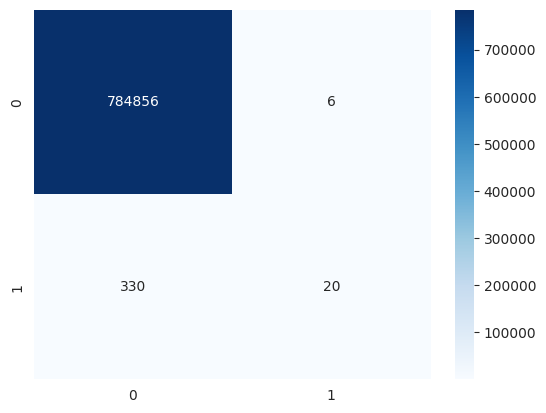

In [24]:
cm = confusion_matrix(y_test, pred_xgb)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

## 1.2 AdaboostClassifier

In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [26]:
pred_clf = clf.predict(X_train)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, pred_clf)
F1_score = f1_score(y_train, pred_clf)
print(f'Accuracy: {accuracy}')
print(f'F1_score: {F1_score}')
print(classification_report(y_train, pred_clf))

Accuracy: 0.999561264703841
F1_score: 0.03366058906030856
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3139444
           1       1.00      0.02      0.03      1402

    accuracy                           1.00   3140846
   macro avg       1.00      0.51      0.52   3140846
weighted avg       1.00      1.00      1.00   3140846



## 1.3 Stacking model - Voting Classifier

In [27]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('clf', clf), ('XGB', XGB)]

# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

## Evaluating Voting Classifier model

In [28]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1_score: {F1_score}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    784862
           1       0.76      0.05      0.10       350

    accuracy                           1.00    785212
   macro avg       0.88      0.53      0.55    785212
weighted avg       1.00      1.00      1.00    785212

Accuracy: 0.9995708165438124
F1_score: 0.10133333333333333


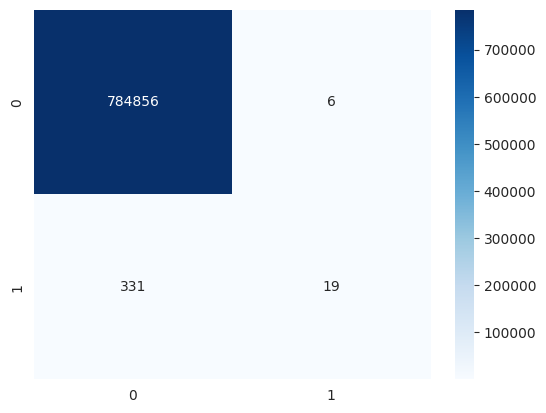

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

## Calculate Roc_curve

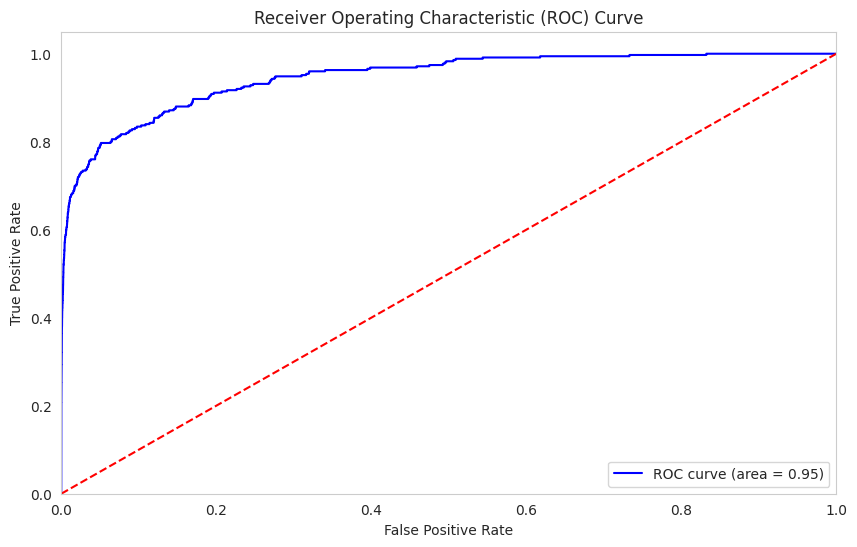

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class
y_scores = VC.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_scores)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Submitted file 

In [31]:
submission_dict = {"Id": [], "churn": []}
for i, j in zip(data['customer_id'], y_pred):
    submission_dict['Id'].append(i)
    submission_dict['churn'].append(j)

submission_df = pd.DataFrame(submission_dict)  # This line creates the DataFrame

submission_file = submission_df.groupby('Id')['churn'].mean().reset_index().dropna()

submission_file.to_csv('submission.csv', index=False)

In [32]:
submission_file.head()

,Id,churn
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


## Summary and Conclusion

In this notebook, we explored a Neo Bank customer churn dataset with a focus on explainability and interpretable machine learning models. The workflow included:

- **Data Exploration & Cleaning:** We loaded, inspected, and preprocessed the data, handling missing values, removing duplicates, and engineering features such as age and date components.
- **Exploratory Data Analysis:** We visualized churn distributions, feature trends, and correlations to understand key drivers of churn, especially those related to fraud.
- **Modeling:** We trained and evaluated interpretable supervised models, including XGBoost and AdaBoost, and compared their performance. Although a Voting Classifier (stacking) was demonstrated, stakeholders' requirements restrict deployment to a single model.
- **Evaluation:** Model performance was assessed using accuracy, F1-score, confusion matrices, and ROC curves, with results indicating the challenges of imbalanced data.
- **Submission:** Predictions were formatted for submission as required.

**Conclusion:**  
The analysis highlighted the importance of explainable models in high-stakes financial applications. While advanced ensemble methods can improve performance, stakeholder trust and regulatory requirements may necessitate simpler, more interpretable models.

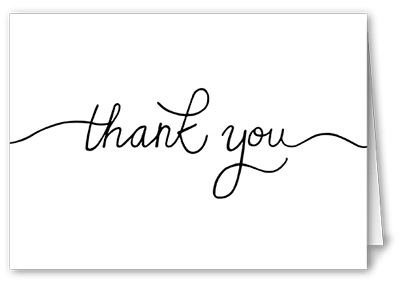